<a href="https://colab.research.google.com/github/elliotpaquette/elliotpaquette/blob/master/sDANA_simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is companion code for the NeurIPS submission: "Dynamics of stochastic momentum methods on large--scale quadratic models."  Figures in the paper were generated using this code (in fact an earlier version).  (We have omitted stochastic heavy ball and routines for generating integrals against Marchenko--Pastur, but SGD, dana and Volterra losses can all be generated using this file.)

In [115]:
import numpy as np
import scipy as sp
from scipy.sparse import linalg as splinalg
from scipy.signal import fftconvolve as fftconvolve
from scipy.integrate import quad
from scipy.integrate import solve_ivp

import tensorflow as tf
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [116]:
def dana_lsq( A, b, t_max, theta=4, gamma_1=-1, gamma_2=-1,oversample=1):
  """Runs the sDANA algorithm to solve the least squares problem Ax=b.
  The special case of gamma_1 =0 recovers SGD.

  Parameters
  ----------
  A : matrix
      The data matrix (2d-array) of some shape (n,d)
  b : vector
      The target vector
  t_max : float
      The number of epochs (algorithm will run t_max * n steps)
  theta : float, optional
      The momentum paramter, defaults to 4
  gamma_1: float, optional
      (Momentum) stepsize parameter, defaults to gamma_2/4
  gamma_2: float, optional
      (Additional gradient) stepsize parameter, defaults to n/||A||**2, with
      Frobenius norm ||A||.
  oversample: int, optional
      return additional losses, by a multiple of oversample 
      (note integer division is performed, so every n//oversample is returned)

  Returns
  -------
  t_grid: numpy.array(float)
      the best fit vector x
  losses : numpy.array(float)
      an array of floats that are the losses of the least squares problem, one
      per epoch
  """

  n, d = A.shape

  if gamma_2==-1:
    gamma_2 = n/np.linalg.norm(A)**2
  if gamma_1==-1:
    gamma_1 = gamma_2/4

  steps = int(n * t_max)

  def loss(x):
    z = A@x - b
    return (1/2)*np.sum( z*z)
  
  losses = []

  x = np.random.randn(d)/ (np.sqrt(2*n))
  y = np.zeros(d)

  for t in range(steps):
    i = np.random.randint(0,n, size =1)[0]
    grad_i = A[i] * (A[i].dot(x) - b[i])
    if t % (n//oversample) == 0:
      losses.append(loss(x))
    y = (1- theta/(n+t))*y + grad_i * (gamma_1/n)
    x = x - y - gamma_2 * grad_i
  return x, np.array(losses)

In [117]:
def picard_volterra(f, K, t_max, n_grid):
  """Runs Picard iteration to approximate a convolution Volterra equation
  sol = f + K*sol, where * denotes convolution, 
  and where K is assumed to be positive.

  Parameters
  ----------
  f : callable
      Forcing function that takes as input a vector of times to be evaluated
  K : callable
      Convolution kernel that takes as input a vector of times to be evaluated
  t_max : float
      The number of epochs 
  n_grid : int
      The number of grid points

  Returns
  -------
  t_grid: numpy.array(float)
      the time steps used, which will discretize (0,t_max) into n_grid points
  sol: numpy.array(float)
      the values of the solution to the convolution Volterra equation at the time steps
  """

  t_grid = np.linspace(0, t_max, n_grid)
  delta = t_max/n_grid
  I = delta*K(t_grid)
  F = f(t_grid)

  for i in range(n_grid):
    if I[i] > 0.001 and (i+1) < n_grid:
      if i% 10 == 0:
        print("Using quadrature to refine kernel with t="+str(t_grid[i])+" as kernel output="+str(I[i]))
      I[i] = quad(K, t_grid[i], t_grid[i+1])[0]
  
  knorm = np.sum(I)
  print( "kernel norm computed as "+str(knorm))

  loops = np.int(np.ceil(np.log(0.0001)/np.log(knorm)))
  print( "will use "+str(loops)+" iterations")

  sol = np.zeros(n_grid)
  for i in range(loops):
    sol = F + fftconvolve(sol, I, mode="full")[0:n_grid]
  return t_grid, sol
  

In [118]:
def empirical_volterra(eiglist, t_max, n_grid, R, R_tilde, theta=4, gamma_1=-1, gamma_2=-1):
  """Generates the Volterra model for sDANA for a list of eigenvalues eiglist

  Parameters
  ----------
  eiglist : vector
      The eigenvalues of Gauss--Newton matrix of the least squares problem,
      n is the number of eigenvalues.
  t_max : float
      The number of epochs (algorithm will run t_max * n steps)
  n_grid : int
      The number of grid points
  R : float
      The signal parameter.
  R_tilde: float
      The noise parameter.
  theta : float, optional
      The momentum paramter, defaults to 4
  gamma_1: float, optional
      (Momentum) stepsize parameter, defaults to gamma_2/4
  gamma_2: float, optional
      (Additional gradient) stepsize parameter, defaults to n/||A||**2, with
      Frobenius norm ||A|| -- Frobenius squared of ||A|| is also the sum of 
      the eigenvalues

  Returns
  -------
  t_grid: numpy.array(float)
      the time steps used, which will discretize (0,t_max) into n_grid points
  sol: numpy.array(float)
      the values of the solution to the convolution Volterra equation at the time steps
  """
  lmin = np.min(eiglist)
  lmax = np.max(eiglist)
  n_eig= len(eiglist)

  if gamma_2==-1:
    gamma_2 = len(eiglist)/np.sum(eiglist)
  if gamma_1==-1:
    gamma_1 = gamma_2/4

  def K(t):
    def Ktwo(x,t):
      if np.isclose(x,0):
        return t*0
      omega = 4 * gamma_1 - gamma_2**2 * x + 0j
      angle = np.complex256(np.sqrt(x * omega) * t)
      return np.where((np.abs(np.imag(angle)) < 10)*
                      ( gamma_2*t*x < 10),
                      x * np.exp( -gamma_2*t*x ) * (
                      gamma_1**2 * x * t**2 * np.sinc(angle/(2*np.pi))**2+
                      (4*gamma_1 - omega) * np.cos( angle ) +
                      (omega - 2*gamma_1)*gamma_2 * x * t * np.sinc(angle/(np.pi))
                      ), 
                      0
      )
    ktally = 0
    return np.sum(np.array([np.real(Ktwo(eig,t)) for eig in eiglist]),axis=0)/n_eig


  def dXdt(X,eig,t):
    J,dJ,ddJ = X
    A = (0
        +(4*theta + 4*theta**2)/((1+t)**3)
        -(4*gamma_2 * eig * theta)/( (1+t)**2 ) 
        +(4*gamma_1*eig*theta)/(1+t)
        -(4*gamma_1*gamma_2*eig**2)
    )
    B = (0
         -(5*theta+2*theta**2)/((1+t)**2)
         +4*gamma_2*eig*theta/(1+t)
         -4*gamma_1*eig
         -2*gamma_2**2 * eig ** 2
         )
    C = 3*theta/(1+t) - 3*gamma_2*eig
    return [dJ, ddJ,A*J + B*dJ + C*ddJ]

  def forcing(times):
    tmin = min(times)
    tmax = max(times)
    ftally = np.zeros_like(times)
    for eig in eiglist:
      diffeq = lambda t,y : dXdt(y,eig,t)
      ICs = (R*eig + R_tilde)*np.array([1,(2*theta-2*gamma_2*eig),(2*theta-2*gamma_2*eig)**2-2*gamma_1*eig-2*theta ])
      sol = solve_ivp( diffeq, [tmin,tmax], ICs, t_eval=times)
      ftally += sol.y[0]
    return ftally * np.power( (1+times), -theta) * 0.5 / n_eig

  t_grid, sol = picard_volterra(forcing,K,t_max,n_grid)

  return t_grid, sol*np.power( (1+t_grid), -theta)



Demonstrate the Volterra equation with empirical eigenvalues vs sDANA on Gaussian data.  

Using quadrature to refine kernel with t=0.0 as kernel output=0.07478783417958436147
Using quadrature to refine kernel with t=0.5005005005005005 as kernel output=0.018557051723427243303
Using quadrature to refine kernel with t=1.001001001001001 as kernel output=0.0065926804612851188836
Using quadrature to refine kernel with t=1.5015015015015016 as kernel output=0.0030886310449407796137
Using quadrature to refine kernel with t=2.002002002002002 as kernel output=0.0017307167359426997051
Using quadrature to refine kernel with t=2.5025025025025025 as kernel output=0.0010843500221885167293
kernel norm computed as 0.62531044371895912925
will use 20 iterations


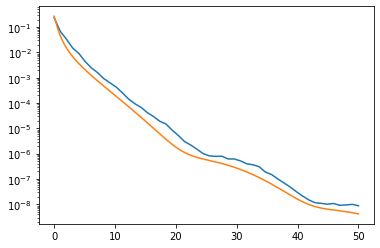

In [124]:
n=500
d=1000
A = np.random.randn(n,d)
b = np.random.randn(n)
invnorms=sp.sparse.diags(1/np.linalg.norm(A,axis=1))
A = invnorms@A
b = invnorms@b*0.1
#The resulting R-tilde value will be the norm-squared of b, 
#which in this configuration is given by (n/d)*(0.01)/2

t_max = 50

exp_DANA = dana_lsq(A,b,t_max)[1]

plt.yscale('log')
plt.plot(np.linspace(0,t_max,t_max), exp_DANA, label="DANA")

n_grid_MP = 500
ratio = np.float(d)/np.float(n)
n_grid = 1000
eigs = np.linalg.eigvalsh(A@A.transpose())
t_grid, v_emp = empirical_volterra(eigs,t_max,n_grid,0.50,((n/d)*0.01)/2)
#The value of R is given by 0.5, which is due to initialization
plt.plot(t_grid, v_emp, label="Empirical Volterra")



Demonstrate the Volterra equation with empirical eigenvalues vs sDANA on MNIST.  The tendency for the Volterra equation to underestimate the true loss for small values of time is normal.  It is in part of explained from having replaced the true non-convolution Volterra equation with a convolution--Volterra equation, which only holds as time tends to infinity.

Using quadrature to refine kernel with t=0.0 as kernel output=2.5374336150524616825
Using quadrature to refine kernel with t=1.001001001001001 as kernel output=0.0033007801990324557607
Using quadrature to refine kernel with t=2.002002002002002 as kernel output=0.0012837635811139476016
kernel norm computed as 0.5695758920279302068
will use 17 iterations


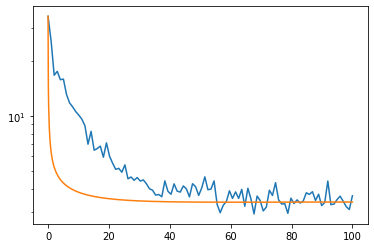

In [120]:
(x_train, y_train), (x_test,y_test) = tf.keras.datasets.mnist.load_data()
flat = x_train.reshape(60000,28*28)
scaler = StandardScaler().fit(flat)
rescaled_flat =scaler.transform(flat)
firstdigits = y_train

A = rescaled_flat[0:1000]
b = y_train[0:1000]
invnorms=sp.sparse.diags(1/np.linalg.norm(A,axis=1))
A = invnorms@A
b = invnorms@b

t_max = 100

exp_DANA = dana_lsq(A,b,t_max)[1]

plt.yscale('log')
plt.plot(np.linspace(0,t_max,t_max), exp_DANA, label="DANA")

n_grid_MP = 500
n_grid = 1000
eigs = np.linalg.eigvalsh(A@A.transpose())
#The Signal/Noise ratio seems empirically to be about 5-to-1
t_grid, v_emp = empirical_volterra(eigs,t_max,n_grid,5.0,1.0)
#Empirically align the Volterra vs experiment.  
plt.plot(t_grid, v_emp*exp_DANA[0]/v_emp[0], label="Empirical Volterra")



In the following, we double up the pictures from MNIST, instead showing pairs of adjacent images from the dataset.  This allows us to double the length of the feature vector.  We still only attempt to explain the first digit (i.e. we make the target the class vector of only the first)

Using quadrature to refine kernel with t=0.0 as kernel output=1.2919166733003694485
Using quadrature to refine kernel with t=1.001001001001001 as kernel output=0.0050250823619738156534
Using quadrature to refine kernel with t=2.002002002002002 as kernel output=0.0019343581463625907125
Using quadrature to refine kernel with t=3.0030030030030033 as kernel output=0.0011230363345241163145
kernel norm computed as 0.60864308473077023605
will use 19 iterations


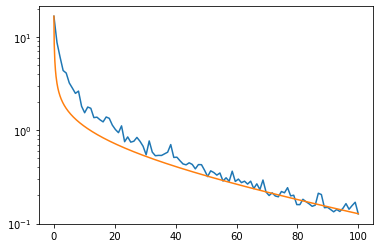

In [121]:
(x_train, y_train), (x_test,y_test) = tf.keras.datasets.mnist.load_data()
flat = x_train.reshape(60000,28*28)
flat = flat.reshape(30000,28*28*2)
scaler = StandardScaler().fit(flat)
rescaled_flat =scaler.transform(flat)
firstdigits = y_train[0:2000:2]

A = rescaled_flat[0:1000]
b = y_train[0:2000:2]
invnorms=sp.sparse.diags(1/np.linalg.norm(A,axis=1))
A = invnorms@A
b = invnorms@b

#Anorm= np.linalg.norm(A)**2

t_max = 100

exp_DANA = dana_lsq(A,b,t_max)[1]

plt.yscale('log')
plt.plot(np.linspace(0,t_max,t_max), exp_DANA, label="DANA")

n_grid_MP = 500
n_grid = 1000
eigs = np.linalg.eigvalsh(A@A.transpose())
t_grid, v_emp = empirical_volterra(eigs,t_max,n_grid,5.0,1.0)
plt.plot(t_grid, v_emp*exp_DANA[0]/v_emp[0], label="Empirical Volterra")



Full MNIST run.  With all 60000 images, the loss that can be attained is much less, and not even a full pass over the dataset is necessary. We increase the sampling frequency to 100/epoch.  

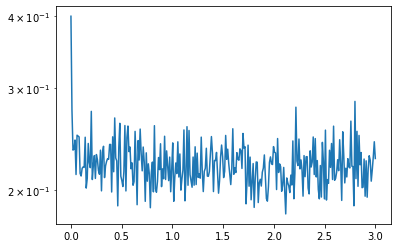

In [122]:
(x_train, y_train), (x_test,y_test) = tf.keras.datasets.mnist.load_data()
flat = x_train.reshape(60000,28*28)
scaler = StandardScaler().fit(flat)
rescaled_flat =scaler.transform(flat)

A = rescaled_flat
b = y_train/100
invnorms=sp.sparse.diags(1/np.linalg.norm(A,axis=1))
A = invnorms@A
b = invnorms@b

#Anorm= np.linalg.norm(A)**2

t_max = 3

exp_DANA = dana_lsq(A,b,t_max, oversample=100)[1]

plt.yscale('log')
plt.plot(np.linspace(0,t_max,t_max*100), exp_DANA, label="DANA")

#n_grid_MP = 500
#n_grid = 1000
#eigs = np.linalg.eigvalsh(A@A.transpose())
#t_grid, v_emp = empirical_volterra(eigs,t_max,n_grid,5.0,1.0)
#plt.plot(t_grid, v_emp*exp_DANA[0]/v_emp[0], label="Empirical Volterra")

